<a href="https://colab.research.google.com/github/meghana2343/ADS-Project/blob/main/stockprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
dataset = pd.read_csv('C://Users/Sulthan/Downloads/HistoricalData_1761495123702.csv')
dataset.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/C://Users/Sulthan/Downloads/HistoricalData_1761495123702.csv'

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')


Saving HistoricalData_1761495123702.csv to HistoricalData_1761495123702.csv
User uploaded file "HistoricalData_1761495123702.csv" with length 6794 bytes


Once the file is uploaded, you can read it using pandas like this. Make sure to replace `'HistoricalData_1761495123702.csv'` with the exact name of the file you uploaded if it's different.

In [ ]:
import pandas as pd

dataset = pd.read_csv('dataset.txt')
display(dataset.head())

,Date,Close/Last,Volume,Open,High,Low
0,10/24/2025,$224.21,38685050,$221.97,$225.40,$221.90
1,10/23/2025,$221.09,31540000,$219.00,$221.30,$218.18
2,10/22/2025,$217.95,44308540,$219.30,$220.005,$216.52
3,10/21/2025,$222.03,50494570,$218.43,$223.32,$217.99
4,10/20/2025,$216.48,38882820,$213.88,$216.69,$213.59


In [ ]:

dataset.shape


(126, 6)

In [ ]:
#preprocessing data


In [ ]:
dataset.isna().sum()

,0
Date,0
Close/Last,0
Volume,0
Open,0
High,0
Low,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        126 non-null    object
 1   Close/Last  126 non-null    object
 2   Volume      126 non-null    int64 
 3   Open        126 non-null    object
 4   High        126 non-null    object
 5   Low         126 non-null    object
dtypes: int64(1), object(5)
memory usage: 6.0+ KB


In [ ]:
#converting the 'Date' column into 'datetime' dtype
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        126 non-null    datetime64[ns]
 1   Close/Last  126 non-null    object        
 2   Volume      126 non-null    int64         
 3   Open        126 non-null    object        
 4   High        126 non-null    object        
 5   Low         126 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 6.0+ KB


In [ ]:
#making the 'Date ' col as index
dataset.set_index('Date',inplace=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 126 entries, 2025-10-24 to 2025-04-28
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Close/Last  126 non-null    object
 1   Volume      126 non-null    int64 
 2   Open        126 non-null    object
 3   High        126 non-null    object
 4   Low         126 non-null    object
dtypes: int64(1), object(4)
memory usage: 5.9+ KB


In [ ]:
dataset.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2025-10-24,$224.21,38685050,$221.97,$225.40,$221.90
2025-10-23,$221.09,31540000,$219.00,$221.30,$218.18
2025-10-22,$217.95,44308540,$219.30,$220.005,$216.52
2025-10-21,$222.03,50494570,$218.43,$223.32,$217.99
2025-10-20,$216.48,38882820,$213.88,$216.69,$213.59


In [ ]:
#sorting the indexes
dataset.sort_index(inplace=True)

In [ ]:
# Remove $ and convert selected columns to numeric
cols = ['Close/Last', 'Open', 'High', 'Low']
for col in cols:
    dataset[col] = dataset[col].replace({r'\$': ''}, regex=True).astype(float)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 126 entries, 2025-04-28 to 2025-10-24
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close/Last  126 non-null    float64
 1   Volume      126 non-null    int64  
 2   Open        126 non-null    float64
 3   High        126 non-null    float64
 4   Low         126 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 5.9 KB


In [ ]:
#data normalization
scaler=MinMaxScaler()
scaler_values=scaler.fit_transform(dataset)
dataset[dataset.columns] = scaler_values




In [ ]:
scaler_values

array([[0.06094389, 0.11851226, 0.14337339, 0.09609665, 0.10732705],
       [0.05518395, 0.20209809, 0.03288463, 0.05512639, 0.08589721],
       [0.        , 0.33584762, 0.        , 0.        , 0.        ],
       [0.10739502, 0.52484369, 0.15285934, 0.12559665, 0.15383247],
       [0.10330732, 0.5608573 , 0.16740446, 0.14553903, 0.13426996],
       [0.03586027, 0.13824151, 0.0784172 , 0.05817844, 0.11879779],
       [0.01096247, 0.07979441, 0.04336435, 0.0535316 , 0.08892051],
       [0.07971014, 0.22522254, 0.06125215, 0.11040892, 0.10955006],
       [0.14232627, 0.1959237 , 0.16731412, 0.17249071, 0.17730749],
       [0.16053512, 0.0832505 , 0.20245731, 0.17918216, 0.21892228],
       [0.45001858, 0.53414111, 0.51567441, 0.49460967, 0.47839232],
       [0.50074322, 0.34591788, 0.52235974, 0.55371747, 0.55575316],
       [0.47993311, 0.1706625 , 0.52904508, 0.49962825, 0.53352303],
       [0.38554441, 0.42664353, 0.43870268, 0.40576208, 0.42367064],
       [0.3933482 , 0.2184461 , 0.

In [ ]:
dataset_scaled=pd.DataFrame(scaler_values,columns=dataset.columns, index=dataset.index)

In [ ]:
dataset_scaled.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2025-04-28,0.060944,0.118512,0.143373,0.096097,0.107327
2025-04-29,0.055184,0.202098,0.032885,0.055126,0.085897
2025-04-30,0.000000,0.335848,0.000000,0.000000,0.000000
2025-05-01,0.107395,0.524844,0.152859,0.125597,0.153832
2025-05-02,0.103307,0.560857,0.167404,0.145539,0.134270


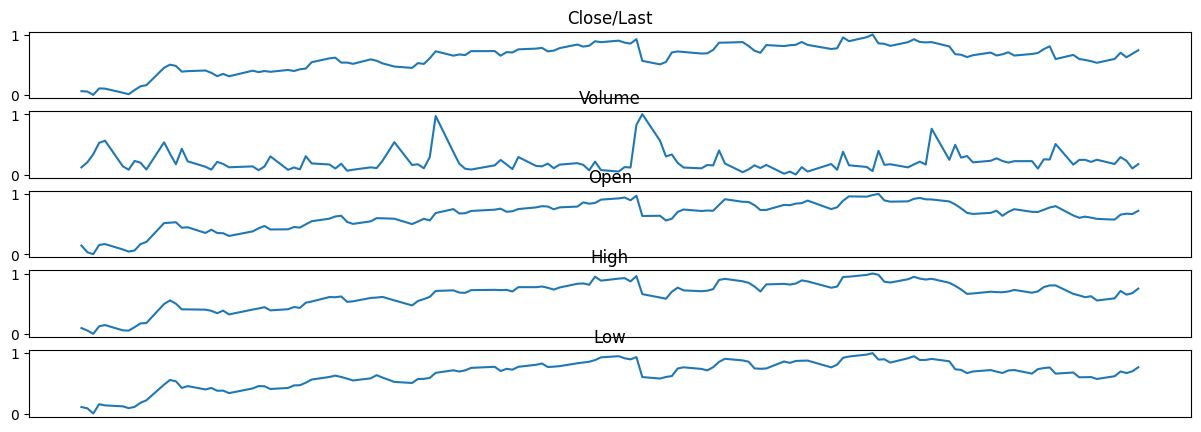

In [ ]:
#plotting columns
plt.rcParams['figure.figsize']=(15,5)
figure,ax=plt.subplots(5)

for ax,col in zip(ax, dataset_scaled.columns):
    ax.plot(dataset_scaled[col])
    ax.set_title(col)
    ax.axes.get_xaxis().set_visible(False)





In [ ]:
## creating the sliding window sequence

def create_sequences(data,window_size):
    x = []
    y = []
    for i in range(window_size, len(data)):
        x.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(x),np.array(y)

In [ ]:
window_size=50
x, y = create_sequences(dataset_scaled, 30)

In [ ]:
x.shape, y.shape

((96, 30, 5), (96, 5))

In [ ]:
x

array([[[0.06094389, 0.11851226, 0.14337339, 0.09609665, 0.10732705],
        [0.05518395, 0.20209809, 0.03288463, 0.05512639, 0.08589721],
        [0.        , 0.33584762, 0.        , 0.        , 0.        ],
        ...,
        [0.43645485, 0.30419253, 0.49471497, 0.51598513, 0.51058154],
        [0.54162022, 0.18393292, 0.54621014, 0.53568587, 0.5628668 ],
        [0.60497956, 0.16680494, 0.58867106, 0.60966543, 0.60519296]],

       [[0.05518395, 0.20209809, 0.03288463, 0.05512639, 0.08589721],
        [0.        , 0.33584762, 0.        , 0.        , 0.        ],
        [0.10739502, 0.52484369, 0.15285934, 0.12559665, 0.15383247],
        ...,
        [0.54162022, 0.18393292, 0.54621014, 0.53568587, 0.5628668 ],
        [0.60497956, 0.16680494, 0.58867106, 0.60966543, 0.60519296],
        [0.61668525, 0.09948921, 0.62535008, 0.60669145, 0.62777877]],

       [[0.        , 0.33584762, 0.        , 0.        , 0.        ],
        [0.10739502, 0.52484369, 0.15285934, 0.12559665, 0.1

In [ ]:
y

array([[0.61668525, 0.09948921, 0.62535008, 0.60669145, 0.62777877],
       [0.53474545, 0.17891809, 0.63673322, 0.61988848, 0.6053708 ],
       [0.53548867, 0.06322017, 0.53500768, 0.5302974 , 0.5776276 ],
       [0.51430695, 0.08002905, 0.50212305, 0.53903346, 0.54721679],
       [0.58862876, 0.11910065, 0.54458397, 0.59498141, 0.58242931],
       [0.56484578, 0.10724076, 0.59671154, 0.60148699, 0.63507025],
       [0.52211074, 0.22876279, 0.59481435, 0.61171004, 0.59558954],
       [0.46952806, 0.53558353, 0.58740627, 0.55464684, 0.52322426],
       [0.4468599 , 0.15897587, 0.4990514 , 0.47100372, 0.50613729],
       [0.52675585, 0.16954008, 0.54142199, 0.54442379, 0.57255913],
       [0.5122631 , 0.10396803, 0.58623182, 0.57583643, 0.5737151 ],
       [0.60758082, 0.28935723, 0.55921944, 0.61310409, 0.58972079],
       [0.72240803, 0.96988545, 0.6820851 , 0.71096654, 0.67383959],
       [0.64975845, 0.37259099, 0.74713163, 0.72063197, 0.71616575],
       [0.66963954, 0.17823347, 0.

In [ ]:
#train, test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape,


((76, 30, 5), (20, 30, 5))

In [ ]:
x_train.shape[1], x_train.shape[1]

(30, 30)

In [ ]:
## lstm models
model= keras.Sequential([
    #adding firsr  lstm layers
    keras.layers.LSTM(units=52, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    keras.layers.Dropout(0.3),
    #adding second lstm layers
    keras.layers.LSTM(units=52, return_sequences=True),
    keras.layers.Dropout(0.3),
    #adding third lstm layers
    keras.layers.LSTM(units=52, return_sequences=False),
    keras.layers.Dropout(0.3),
    #adding output layers
    keras.layers.Dense(y_train.shape[1])



])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#compilation
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError'])

In [ ]:
#early stopping condition
early_stopping=EarlyStopping(monitor='val_loss',
                             patience=30,
                             restore_best_weights=True)


In [ ]:
prediction = model.fit(x_train, y_train, epochs=100, batch_size=3, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - RootMeanSquaredError: 0.1385 - loss: 0.0194 - val_RootMeanSquaredError: 0.0851 - val_loss: 0.0072
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - RootMeanSquaredError: 0.1089 - loss: 0.0120 - val_RootMeanSquaredError: 0.0908 - val_loss: 0.0082
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - RootMeanSquaredError: 0.1381 - loss: 0.0197 - val_RootMeanSquaredError: 0.0886 - val_loss: 0.0078
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - RootMeanSquaredError: 0.1193 - loss: 0.0145 - val_RootMeanSquaredError: 0.0868 - val_loss: 0.0075
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - RootMeanSquaredError: 0.1252 - loss: 0.0159 - val_RootMeanSquaredError: 0.0830 - val_loss: 0.0069
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - RootMeanSquaredError: 0.1297 - loss: 0.0170 - val_RootMeanSquaredError: 0.0843 - val_loss: 0.0071
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - RootMeanSquaredError: 0.0995 - los

In [ ]:
predictions=model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


In [ ]:
prediction.history

{'RootMeanSquaredError': [0.12941595911979675,
  0.12792018055915833,
  0.12327367812395096,
  0.13263802230358124,
  0.11819859594106674,
  0.12336008250713348,
  0.10921002924442291,
  0.12014506012201309,
  0.12818533182144165,
  0.13243502378463745,
  0.13082215189933777,
  0.12259038537740707,
  0.12836158275604248,
  0.1137605533003807,
  0.11870127171278,
  0.11599065363407135,
  0.12184321135282516,
  0.13233764469623566,
  0.11425361037254333,
  0.11702951788902283,
  0.11185657232999802,
  0.11628014594316483,
  0.11689751595258713,
  0.1159195825457573,
  0.11894036829471588,
  0.1205684244632721,
  0.10624108463525772,
  0.11490540951490402,
  0.11297666281461716,
  0.11412264406681061,
  0.11422882974147797,
  0.1206696406006813,
  0.1083565354347229,
  0.11319001019001007,
  0.11414127051830292,
  0.11200463026762009,
  0.11295775324106216,
  0.112201027572155,
  0.11101797223091125,
  0.11534933745861053,
  0.10897879302501678,
  0.11216772347688675,
  0.1104495078325271

In [ ]:
##forecasting the data

predictions[:10]



array([[0.7212145 , 0.19780093, 0.7440205 , 0.7507418 , 0.7565812 ],
       [0.72323436, 0.22664395, 0.7398385 , 0.7520477 , 0.75834894],
       [0.7154039 , 0.26048607, 0.7345823 , 0.7478344 , 0.7468765 ],
       [0.66873705, 0.18005675, 0.6861308 , 0.69420946, 0.7042624 ],
       [0.85610163, 0.24699403, 0.8996839 , 0.89066714, 0.89467454],
       [0.7197603 , 0.2063843 , 0.73998857, 0.7488677 , 0.7550106 ],
       [0.83633757, 0.26966882, 0.87442183, 0.8719745 , 0.8714831 ],
       [0.7397314 , 0.21017557, 0.7436679 , 0.7618798 , 0.77497387],
       [0.5668882 , 0.14414379, 0.5883454 , 0.59478074, 0.60355496],
       [0.59556425, 0.20451277, 0.60965633, 0.62448055, 0.6317098 ]],
      dtype=float32)

In [ ]:
###inverse scaling


predictions_inverse = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

In [ ]:
predictions[:10]

array([[0.7212145 , 0.19780093, 0.7440205 , 0.7507418 , 0.7565812 ],
       [0.72323436, 0.22664395, 0.7398385 , 0.7520477 , 0.75834894],
       [0.7154039 , 0.26048607, 0.7345823 , 0.7478344 , 0.7468765 ],
       [0.66873705, 0.18005675, 0.6861308 , 0.69420946, 0.7042624 ],
       [0.85610163, 0.24699403, 0.8996839 , 0.89066714, 0.89467454],
       [0.7197603 , 0.2063843 , 0.73998857, 0.7488677 , 0.7550106 ],
       [0.83633757, 0.26966882, 0.87442183, 0.8719745 , 0.8714831 ],
       [0.7397314 , 0.21017557, 0.7436679 , 0.7618798 , 0.77497387],
       [0.5668882 , 0.14414379, 0.5883454 , 0.59478074, 0.60355496],
       [0.59556425, 0.20451277, 0.60965633, 0.62448055, 0.6317098 ]],
      dtype=float32)

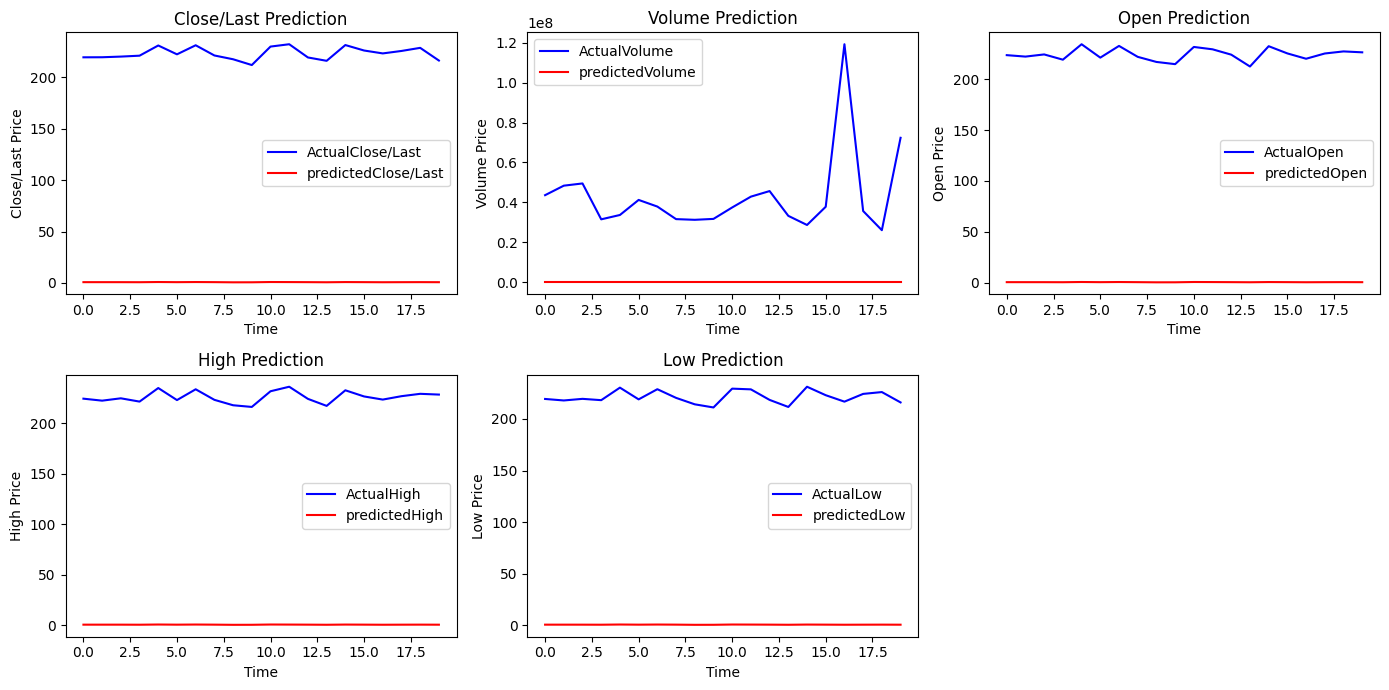

In [ ]:
##3plotting the results

plt.figure(figsize=(14,7))
for i, col in enumerate(dataset_scaled.columns):
  plt.subplot(2,3, i+1)
  plt.plot(y_test_rescaled[:,i], color='blue', label = f'Actual{col}')
  plt.plot(predictions[:, i], color='red', label= f'predicted{col}')
  plt.title(f'{col} Prediction')
  plt.xlabel('Time')
  plt.ylabel(f'{col} Price')
  plt.legend()
  plt.tight_layout()
plt.show()

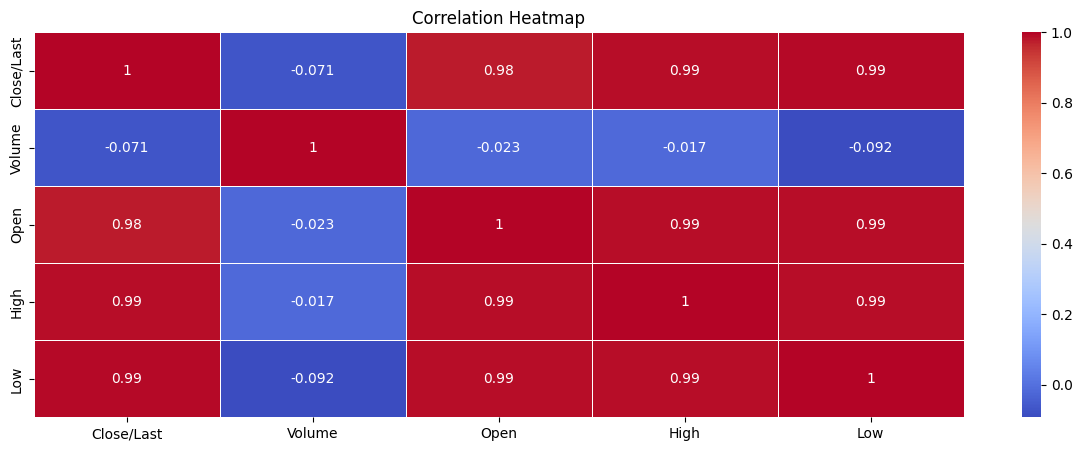

In [ ]:
#  correlation matrix
corr = dataset.corr(numeric_only=True)

#  heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

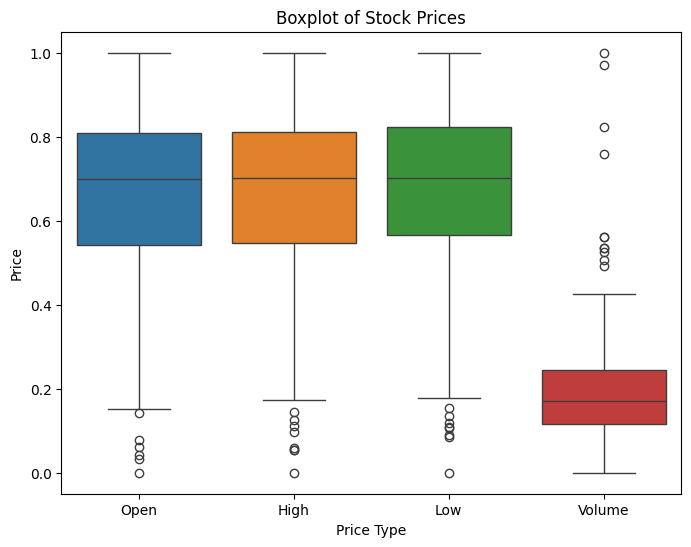

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=dataset[['Open', 'High', 'Low', 'Volume']])
plt.title('Boxplot of Stock Prices')
plt.ylabel('Price')
plt.xlabel('Price Type')
plt.show()

In [ ]:
## Bidirectional LSTM model
model_bilstm = Sequential([
    Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(units=50, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=50, return_sequences=False)),
    Dropout(0.3),
    Dense(y_train.shape[1])
])

# Compilation
model_bilstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError'])

# Early stopping
early_stopping_bilstm = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Training
history_bilstm = model_bilstm.fit(x_train, y_train, epochs=100, batch_size=2, validation_split=0.2, callbacks=[early_stopping_bilstm])

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - RootMeanSquaredError: 0.4027 - loss: 0.1723 - val_RootMeanSquaredError: 0.1662 - val_loss: 0.0276
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - RootMeanSquaredError: 0.2080 - loss: 0.0434 - val_RootMeanSquaredError: 0.1413 - val_loss: 0.0200
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - RootMeanSquaredError: 0.2176 - loss: 0.0479 - val_RootMeanSquaredError: 0.1063 - val_loss: 0.0113
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - RootMeanSquaredError: 0.1985 - loss: 0.0397 - val_RootMeanSquaredError: 0.0988 - val_loss: 0.0098
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - RootMeanSquaredError: 0.1679 - loss: 0.0283 - val_RootMeanSquaredError: 0.1052 - val_loss: 0.0111
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - RootMeanSquaredError: 0.1732 - loss: 0.0301 - val_RootMeanSquaredError: 0.1315 - val_loss: 0.0173
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - RootMeanSquaredError: 0.1667 - loss: 0.0279 -

In [ ]:
# Evaluate LSTM model
lstm_evaluation = model.evaluate(x_test, y_test, verbose=0)
lstm_rmse = lstm_evaluation[1]  # Assuming RootMeanSquaredError is the second metric
print(f"LSTM Model RMSE: {lstm_rmse:.4f}")

# Evaluate Bidirectional LSTM model
bilstm_evaluation = model_bilstm.evaluate(x_test, y_test, verbose=0)
bilstm_rmse = bilstm_evaluation[1]  # Assuming RootMeanSquaredError is the second metric
print(f"Bidirectional LSTM Model RMSE: {bilstm_rmse:.4f}")

LSTM Model RMSE: 0.1013
Bidirectional LSTM Model RMSE: 0.1054


In [ ]:
def build_gru():
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=(seq_length,1)),
        Dropout(0.2),
        GRU(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model